# Naive Bayes Classifier
- Homayoon Alimohammadi - 40208964 - Machine Learning - Dr. Saeedi

## Extract Words

In [1]:
from nltk import SnowballStemmer, PorterStemmer
import re
from glob import glob

def extract_words_in_dir(dir, stemmer=None, remove_special=True, msg_only=True, to_lower=True):
    with open(dir, errors="ignore") as f:
        return extract_words(f.readlines(), stemmer=stemmer, 
                             remove_special=remove_special, msg_only=msg_only, to_lower=to_lower)

def extract_words(lines, stemmer=None, remove_special=True, msg_only=True, to_lower=True):
    if isinstance(lines, str):
        lines = lines.split("\n")

    if msg_only:
        for i, l in enumerate(lines):
            if l.startswith("Lines: "):
                lines = lines[i+1:]
                break
                
    words = []
    for l in lines:
        l = l.replace("\n", "")
        if l == "":
            continue
        splitted = l.split(" ")
        splitted = [s for s in splitted if s != ""]
        if len(splitted) == 0:
            continue

        if stemmer is not None:
            splitted = [stemmer.stem(s) for s in splitted]

        if remove_special:
            splitted = [re.sub(r'[^a-zA-Z\s]', '', s) for s in splitted]

        # remove empty strings
        splitted = [s for s in splitted if s]
        
        if to_lower:
            splitted = [s.lower() for s in splitted]
            
        words.extend(splitted)

    return words

sb_stemmer = SnowballStemmer("english")
pt_stemmer = PorterStemmer()
words = extract_words_in_dir("./dataset/2/Train/74770")
words[:5]

['from', 'samhalperincccbbsuceng', 'dx', 'mhz', 'in']

In [2]:
len(words), len(set(words))

(173, 132)

### Choose the stemmer

In [3]:
ws1 = extract_words_in_dir("./dataset/2/Train/74770", stemmer=sb_stemmer)
ws2 = extract_words_in_dir("./dataset/2/Train/74770", stemmer=pt_stemmer)
for w1, w2 in zip(ws1, ws2):
    if w1 != w2:
        print(w1, w2)

bus bu
ns n
bus bu
dos do
this thi
high highli


It looks like that the "SnowballStemmer" does a better job stemming the words while keeping the semantics, hence we choose it as the default stemmer.

In [4]:
def get_num_occurences(words):
    w2no = {}
    for w in words:
        w2no[w] = w2no.get(w, 0) + 1

    return w2no
    
oc = get_num_occurences(words)

n = 0
for k, v in oc.items():
    if n == 5:
        break
    print(f"{k}: {v}")
    n += 1

from: 2
samhalperincccbbsuceng: 2
dx: 1
mhz: 1
in: 2


## Load the training data

In [5]:
from pathlib import Path

def load_train(base_dir, stemmer=None):
    """
    load train files and returns `class_to_words` = {
        # class 
        1: {
            "random": 10, # <word>: <number_of_occurences>
            ...
        },
        ...
    }
    """
    class_to_words = {}
    for i in range(1, 7):
        dir = base_dir.joinpath(f"{i}/Train/*")
        file_paths = glob(str(dir))
        words = []
        for p in file_paths:
            words.extend(extract_words_in_dir(p, stemmer))

        word_with_num_occur = get_num_occurences(words)
        
        class_to_words[i] = word_with_num_occur
            
    return class_to_words

base_dir = Path("./dataset")
c2w = load_train(base_dir, sb_stemmer)

In [6]:
c2w.keys()

dict_keys([1, 2, 3, 4, 5, 6])

## Naive Bayes classifier implementation

In [7]:
def nb_classifier(class_to_words, target_text, prior, stemmer=None):
    target_words = extract_words(target_text, stemmer=stemmer)
    max_prob = 0
    target_class = -1 # not yet found
    for c, class_words in class_to_words.items():
        c_prob = get_class_prob(class_words, target_words, prior)
        if c_prob > max_prob:
            max_prob = c_prob
            target_class = c

    return target_class

def get_class_prob(class_words, target_words, prior):
    # add 1 to number of occurences of each word in order to normalize non-occuring words impact
    num_all_class_words = sum([n+1 for _, n in class_words.items()])
    prob = prior
    for w in target_words:
        word_prob = (class_words.get(w, 0) + 1) / num_all_class_words
        prob *= word_prob
        prob *= 1100 # normalize prob

    return prob
    

### Test on a sample text

In [8]:
target_words = extract_words("from past to the future", sb_stemmer)

In [9]:
for c in range(1, 7):
    s = sorted(c2w[c].items(), key = lambda x: x[1], reverse=True)
    p = get_class_prob(c2w[c], target_words, 1/6)
    print(f"prob for class {c} is: {p}")

prob for class 1 is: 6.498958437338138
prob for class 2 is: 1.938187902787287
prob for class 3 is: 5.922138743202018
prob for class 4 is: 9.800997404942715
prob for class 5 is: 11.148272509488395
prob for class 6 is: 5.0438555142304216


In [10]:
target_class = nb_classifier(c2w, "from past to the future", 1/6, sb_stemmer)
target_class

5

### Evaluate on the training data

In [11]:
def load_test_for_eval(base_dir):
    """
    returns a class_to_text dictionary
    c2t = {
        1: ["...", "...", "..."],
        2: ["...", "...", "..."],
        ...
    }
    """
    c2t = {}
    for i in range(1, 7):
        path = base_dir.joinpath(f"{i}/Train/*")
        paths = glob(str(path))
        c2t[i] = []
        for p in paths:
            with open(p, "r", errors="ignore") as f:
                c2t[i].append(f.read())

    return c2t

c2t_train = load_test_for_eval(base_dir)

In [12]:
def evaluate(c2w, c2t):
    history = {}
    for i in range(1, 7):
        history[i] = {"all": len(c2t[i]), "correct": 0}
        for t in c2t[i]:
            c = nb_classifier(c2w, t, 1/6, stemmer=sb_stemmer)
            if c == i:
                history[i]["correct"] += 1

        history[i]["accuracy"] = history[i]["correct"] / history[i]["all"] * 100

    return history

history_train = evaluate(c2w, c2t_train)

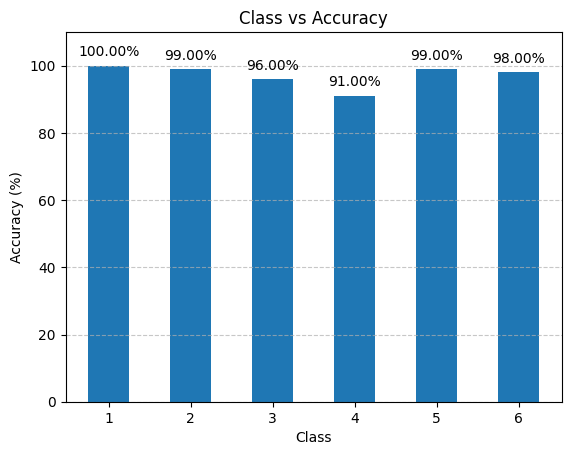

In [13]:
import matplotlib.pyplot as plt

numbers = list(history_train.keys())
accuracies = [entry['accuracy'] for entry in history_train.values()]

plt.bar(numbers, accuracies, tick_label=numbers, width=0.5, align='center')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Class vs Accuracy')
plt.ylim(0, 110)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, accuracy in enumerate(accuracies):
    plt.text(numbers[i], accuracy + 2, f'{accuracy:.2f}%', ha='center', va='bottom')
plt.show()

## Load test data

In [14]:
def load_test(base_dir):
    """
    returns a class_to_text dictionary
    c2t = {
        1: ["...", "...", "..."],
        2: ["...", "...", "..."],
        ...
    }
    """
    c2t = {}
    for i in range(1, 7):
        path = base_dir.joinpath(f"{i}/Test/*")
        paths = glob(str(path))
        c2t[i] = []
        for p in paths:
            with open(p, "r") as f:
                c2t[i].append(f.read())

    return c2t
            
c2t = load_test(base_dir)

In [15]:
c2t.keys()

dict_keys([1, 2, 3, 4, 5, 6])

## Evaluate on test data

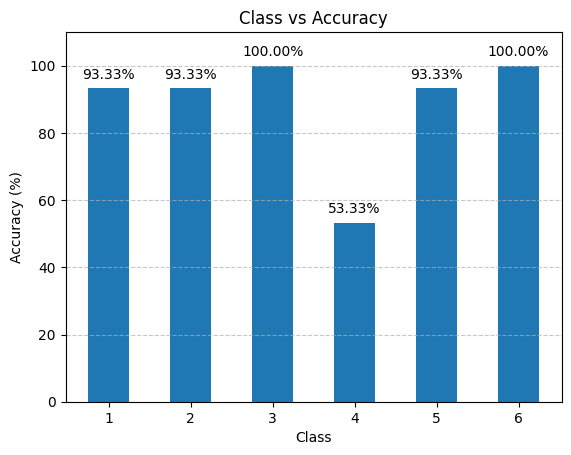

In [16]:
history_test = evaluate(c2w, c2t)

numbers = list(history_test.keys())
accuracies = [entry['accuracy'] for entry in history_test.values()]

plt.bar(numbers, accuracies, tick_label=numbers, width=0.5, align='center')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Class vs Accuracy')
plt.ylim(0, 110)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, accuracy in enumerate(accuracies):
    plt.text(numbers[i], accuracy + 2, f'{accuracy:.2f}%', ha='center', va='bottom')
plt.show()

## Train and Test accuracies side by side

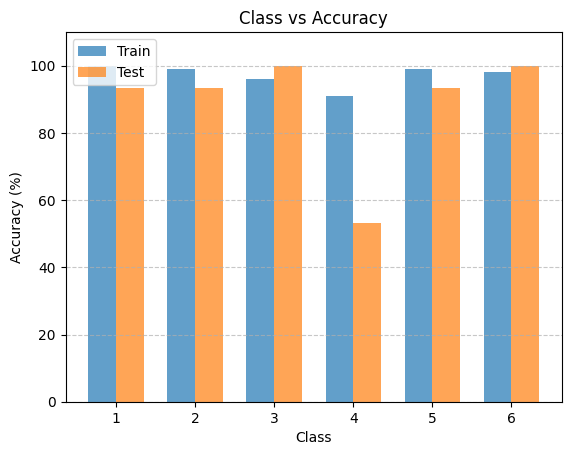

In [17]:
import numpy as np

numbers = list(history_train.keys())
accuracies1 = [entry['accuracy'] for entry in history_train.values()]
accuracies2 = [entry['accuracy'] for entry in history_test.values()]

bar_width = 0.35
index = np.arange(len(numbers))

plt.bar(index, accuracies1, bar_width, label='Train', alpha=0.7)
plt.bar(index + bar_width, accuracies2, bar_width, label='Test', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Class vs Accuracy')
plt.xticks(index + bar_width / 2, numbers)
plt.ylim(0, 110)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()